In [1]:
import torch
import pickle
import datasets
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel

/home/djinb1127/miniconda3/envs/huggingface/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def select_model(input):
  source = {'CodeBERT_small' : {'tokenizer' : "huggingface/CodeBERTa-small-v1", 'model':"huggingface/CodeBERTa-small-v1"},
            'CodeBERT' : {'tokenizer' : "microsoft/codebert-base", 'model':"microsoft/codebert-base"},
            'GraphCodeBERT' : {'tokenizer' : "microsoft/graphcodebert-base", 'model':"microsoft/graphcodebert-base"},
            'Fine-tuning_Example' : {'tokenizer':"mrm8488/codebert-finetuned-clone-detection", 'model':"mrm8488/codebert-finetuned-clone-detection"}
  }
  
  if input in source.keys():
    tokenizer = source[input]['tokenizer']
    model = source[input]['model']
  else:
    print('Return None Obejects')
    print('Models :', source.keys())
    return None, None
  
  return tokenizer, model

In [3]:
tokenizer_path, model_path = select_model('CodeBERT')

tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

DataLoader

In [4]:
from torch.utils.data import Dataset, DataLoader

class Code():
    def __init__(self, path, test_size):
        self.path = path
        self.test_size = test_size
            
    def openFile(self):
        df = pd.read_csv(self.path+'sample_train.csv')
        df = df.sample(frac=1).reset_index(drop=True) # shuffle

        # dataframe to ndarray
        ndarray = pd.DataFrame.to_numpy(df)

        # train/valid/test
        train = ndarray[:-2*self.test_size]
        valid = ndarray[-2*self.test_size:-self.test_size]
        test = ndarray[-self.test_size:]

        return train, valid, test

class code_dataset(Dataset):
    def __init__(self, data):
        self.code1 = data[:, 0].tolist()
        self.code2 = data[:, 1].tolist()

        # token1
        tokens1 = tokenizer(self.code1, padding='max_length', truncation=True, return_tensors='pt')
        self.code1_tensor = tokens1['input_ids']
        self.code1_attn_mask = tokens1['attention_mask']
        # token2
        tokens2 = tokenizer(self.code2, padding='max_length', truncation=True, return_tensors='pt')
        self.code2_tensor = tokens2['input_ids']
        self.code2_attn_mask = tokens2['attention_mask']
        # label
        self.label = torch.from_numpy(data[:, 2].astype(float)).float()

    def __getitem__(self, index):
        return self.code1_tensor[index], self.code1_attn_mask[index], self.code2_tensor[index], self.code2_attn_mask[index], self.label[index]

    def __len__(self):
        return len(self.label)

def dataset_loader(path, test_size, batch_size):
    code = Code(path, test_size=test_size)

    train, valid, test = code.openFile()

    train_dataset = code_dataset(train)
    valid_dataset = code_dataset(valid)
    test_dataset = code_dataset(test)

    train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
    valid_loader = DataLoader(dataset=valid_dataset,batch_size=batch_size,shuffle=True)
    test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

    return train_loader, valid_loader, test_loader

def dataloader_testing():
    # dataloader test
    path = './'
    train_loader, valid_loader, test_loader = dataset_loader(path, test_size=1000, batch_size=3) # batch_size = 3 (toy example)

    data = next(iter(train_loader))

    print('Batch Size :', len(data))
    print('Code1 : ', type(data[0]),'\n', data[0])
    print('Code1_attn :', type(data[1]),'\n', data[1])
    print('Code2 : ', type(data[2]),'\n', data[2])
    print('Code2_attn :', type(data[3]),'\n', data[3])
    print('Labels :', type(data[4]),'\n', data[4])

    # some codes are too long -> 512 tokens are not enough...! (last token was not 1, but 2..)

---

In [5]:
df = pd.read_csv('./sample_train.csv')
df = df.sample(frac=1).reset_index(drop=True) # shuffle

# dataframe to ndarray
data = pd.DataFrame.to_numpy(df)

In [72]:
index = 1
code1 = data[index][0]
code2 = data[index][1]
label = data[index][2]

codes = [code1, code2]

In [74]:
token = {'input_ids':[], 'attention_mask':[]}
for code in codes:
    new_token = tokenizer(code, padding='max_length', truncation=True, return_tensors='pt')
    token['input_ids'].append(new_token['input_ids'][0])
    token['attention_mask'].append(new_token['attention_mask'][0])

token['input_ids'] = torch.stack(token['input_ids'])
token['attention_mask'] = torch.stack(token['attention_mask'])

In [75]:
token['input_ids'].shape

torch.Size([2, 512])

In [76]:
model = AutoModel.from_pretrained(model_path)

In [77]:
output = model(**token)
print(output.keys())

odict_keys(['last_hidden_state', 'pooler_output'])


In [78]:
output['pooler_output']

tensor([[ 0.5089, -0.4746, -0.6461,  ..., -0.0487,  0.0309,  0.1192],
        [ 0.5337, -0.4785, -0.6692,  ..., -0.0834,  0.0104,  0.1604]],
       grad_fn=<TanhBackward0>)

In [79]:
output = model(token['input_ids'], token['attention_mask'])

In [80]:
output['pooler_output']

tensor([[ 0.5089, -0.4746, -0.6461,  ..., -0.0487,  0.0309,  0.1192],
        [ 0.5337, -0.4785, -0.6692,  ..., -0.0834,  0.0104,  0.1604]],
       grad_fn=<TanhBackward0>)

In [81]:
embeddings = output.last_hidden_state
embeddings

tensor([[[ 0.0250,  0.0580, -0.0015,  ..., -0.0936, -0.5305,  0.4674],
         [-0.4141, -0.2251,  0.1883,  ...,  0.0660, -0.6088,  0.7917],
         [-0.2923,  0.0191,  0.2407,  ..., -0.4506, -0.3758,  0.5180],
         ...,
         [ 0.1626,  0.1922,  0.0399,  ...,  0.4207, -0.3523,  0.3910],
         [ 0.1626,  0.1922,  0.0399,  ...,  0.4207, -0.3523,  0.3910],
         [ 0.1626,  0.1922,  0.0399,  ...,  0.4207, -0.3523,  0.3910]],

        [[-0.1467, -0.0290, -0.1276,  ..., -0.1372, -0.5081,  0.5666],
         [-0.2800,  0.1570,  0.2735,  ..., -0.6193, -0.4469,  0.5679],
         [-0.6114,  0.4494,  0.4989,  ..., -0.9709, -0.4944,  0.8472],
         ...,
         [-0.0130, -0.0882,  0.0647,  ..., -0.0228, -0.3797,  0.3714],
         [-0.0130, -0.0882,  0.0647,  ..., -0.0228, -0.3797,  0.3714],
         [-0.0130, -0.0882,  0.0647,  ..., -0.0228, -0.3797,  0.3714]]],
       grad_fn=<NativeLayerNormBackward0>)

In [82]:
att_mask = token['attention_mask']
att_mask.shape

torch.Size([2, 512])

In [83]:
embeddings.size()

torch.Size([2, 512, 768])

In [84]:
mask = att_mask.unsqueeze(-1).expand(embeddings.size()).float()
mask.shape

torch.Size([2, 512, 768])

In [85]:
masked_embeddings = embeddings*mask
masked_embeddings

tensor([[[ 0.0250,  0.0580, -0.0015,  ..., -0.0936, -0.5305,  0.4674],
         [-0.4141, -0.2251,  0.1883,  ...,  0.0660, -0.6088,  0.7917],
         [-0.2923,  0.0191,  0.2407,  ..., -0.4506, -0.3758,  0.5180],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000]],

        [[-0.1467, -0.0290, -0.1276,  ..., -0.1372, -0.5081,  0.5666],
         [-0.2800,  0.1570,  0.2735,  ..., -0.6193, -0.4469,  0.5679],
         [-0.6114,  0.4494,  0.4989,  ..., -0.9709, -0.4944,  0.8472],
         ...,
         [-0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0000,  0.0000],
         [-0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0000,  0.0000],
         [-0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0000,  0.0000]]],
       grad_fn=<MulBackward0>)

In [86]:
summed = torch.sum(masked_embeddings, 1)
summed.shape

torch.Size([2, 768])

In [87]:
sum_weight = torch.clamp(mask.sum(1), min=1e-9)
sum_weight.shape

torch.Size([2, 768])

In [88]:
mean_pooled = summed/sum_weight
mean_pooled.shape

torch.Size([2, 768])

In [91]:
import torch.nn.functional as F

F.cosine_similarity(mean_pooled[0], mean_pooled[1], dim=0)

tensor(0.9822, grad_fn=<DivBackward0>)

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
#Let's calculate cosine similarity for sentence 0:
# convert from PyTorch tensor to numpy array
mean_pooled = mean_pooled.detach().numpy()
# calculate
cosine_similarity(
    [mean_pooled[0]],
    mean_pooled[1:]
)

array([[0.98226416]], dtype=float32)

---

Fine-tuning

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class FineTuningNet(nn.Module):
    def __init__(self, emb_dim):
        super(FineTuningNet, self).__init__()
        self.codeBERT = AutoModel.from_pretrained(model_path, return_dict=False)
        self.fc = nn.Linear(self.codeBERT.config.hidden_size, emb_dim) # Fine-tuning Layer : 768 -> num_class
        self.emb_dim = emb_dim

    def forward(self, code1, code2):
       _, imd1 = self.codeBERT(code1) # intermediate embedding for code1
       _, imd2 = self.codeBERT(code2) # intermediate embedding for code2
       imd1 = torch.relu(self.fc(imd1))
       imd2 = torch.relu(self.fc(imd2))
       imd = torch.bmm(imd1.view(-1,1,self.emb_dim), imd2.view(-1,self.emb_dim,1)).reshape(-1) # apply inner-product to calculate this two embeddings' similarity
       outputs = torch.sigmoid(imd)
       return outputs

# class FineTuningNet(nn.Module):
#     def __init__(self):
#         super(FineTuningNet, self).__init__()
#         self.codeBERT = AutoModel.from_pretrained(model_path, return_dict=False)
#         self.dropout = torch.nn.Dropout(0.1)
#         self.fc = nn.Linear(2*self.codeBERT.config.hidden_size, 1) # Fine-tuning Layer : 768 -> num_class

#     def forward(self, code1, code2):
#        _, imd1 = self.codeBERT(code1) # intermediate embedding for code1
#        _, imd2 = self.codeBERT(code2) # intermediate embedding for code2
#        imd1 = self.dropout(imd1)
#        imd2 = self.dropout(imd2)
#        imd = torch.cat((imd1, imd2), dim=1)
#        imd = self.fc(imd).reshape(-1)
#        outputs = torch.sigmoid(imd)
#        return outputs

In [6]:
path = './'
train_loader, valid_loader, test_loader = dataset_loader(path, test_size=1000, batch_size=256)

emb_dim = 256
# model = FineTuningNet(emb_dim=emb_dim) # embedding dimension = 256
model = FineTuningNet()
for param in model.codeBERT.parameters():
    param.requires_grad = False

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

loss_fn = nn.BCELoss().to(device)
optimizer = optim.AdamW(model.parameters())

num_epochs = 5
loss_list = []

In [7]:
from tqdm import tqdm

model = model.to(device)
model.train()

for epoch in range(num_epochs):
    
    with tqdm(train_loader, unit='batch') as progress:
        for (codes1, codes2, labels) in progress:
            progress.set_description(f"Epoch {epoch+1}")

            optimizer.zero_grad()

            codes1 = codes1.to(device)
            codes2 = codes2.to(device)
            labels = labels.to(device)

            outputs = model(codes1, codes2)

            loss = loss_fn(outputs, labels)
            loss.backward()

            loss_list.append(loss.item())
            optimizer.step()

            progress.set_postfix(loss=loss.item())

Epoch 5: 100%|██████████| 63/63 [03:01<00:00,  2.88s/batch, loss=0.686]


In [10]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'step')

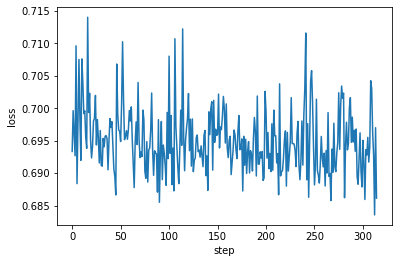

In [11]:
plt.plot(loss_list)
plt.ylabel('loss')
plt.xlabel('step')

In [23]:
codes1.shape

torch.Size([98, 512])

In [24]:
codes2.shape

torch.Size([98, 512])

In [25]:
_, imb1 = model.codeBERT(codes1)

In [27]:
print(imb1.shape)

torch.Size([98, 768])


In [32]:
model.parameters

<bound method Module.parameters of FineTuningNet(
  (codeBERT): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
    

In [35]:
model.codeBERT.parameters

<bound method Module.parameters of RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affin

In [37]:
model.codeBERT.config

RobertaConfig {
  "_name_or_path": "microsoft/codebert-base",
  "architectures": [
    "RobertaModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "return_dict": false,
  "transformers_version": "4.19.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}